# Installation

In [ ]:
# pip install datasets trl transformers accelerate matplotlib ipywidgets

# Dataset Preparation

In [1]:
from datasets import load_dataset

DATASET = "dpo_avg.csv"
DPO_PATH = "Qwen2-5B-DPO-AVG"

# DATASET = "dpo_length_prior.csv"
# DPO_PATH = "Qwen2-5B-DPO-LENGTH-PRIOR"


dataset = load_dataset("csv", data_files=f"dpo_datasets/{DATASET}", split="train")

df = dataset.to_pandas()
df.head(2)

,prompt,chosen,rejected,score_chosen,score_rejected
0,Persona: I love nice hotels. I would like to g...,"If you love nice hotels, the Westin St. Franci...","The hotel is owned by Marriott International, ...",0.7933,0.5460
1,Persona: I am willing to start a seminary in N...,"The New Brunswick Theological Seminary, which ...",Before its establishment as an independent ent...,0.9843,0.4201


In [2]:
print(dataset.column_names)
print(len(dataset))
dataset.shape

['prompt', 'chosen', 'rejected', 'score_chosen', 'score_rejected']
1865


(1865, 5)

In [3]:
# train_dataset = dataset.train_test_split(train_size=1000, seed=42)["train"]

train_dataset = dataset

# DPO Trainer

In [4]:
from trl import DPOConfig, DPOTrainer
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

## Simple DPO

In [ ]:
train_dataset = train_dataset.remove_columns(["score_chosen", "score_rejected"])

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-0.5B-Instruct", torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")

training_args = DPOConfig(
    per_device_train_batch_size=2,  # or 2
    gradient_accumulation_steps=4,  # to simulate larger batch size
    output_dir="Qwen2-5B-DPO",
    logging_steps=50,
)

trainer = DPOTrainer(model = model, args = training_args, processing_class = tokenizer, train_dataset= train_dataset)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Extracting prompt in train dataset:   0%|          | 0/1865 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1865 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1865 [00:00<?, ? examples/s]

In [7]:
trainer.train()

Step,Training Loss
50,0.324600
100,0.232800
150,0.212800
200,0.225900
250,0.168200
300,0.066300
350,0.070600
400,0.064400
450,0.056300
500,0.032100


TrainOutput(global_step=699, training_loss=0.10973983116245406, metrics={'train_runtime': 1160.1469, 'train_samples_per_second': 4.823, 'train_steps_per_second': 0.603, 'total_flos': 0.0, 'train_loss': 0.10973983116245406, 'epoch': 2.990353697749196})

In [8]:
log_history = trainer.state.log_history

print(log_history[0].keys())

dict_keys(['loss', 'grad_norm', 'learning_rate', 'rewards/chosen', 'rewards/rejected', 'rewards/accuracies', 'rewards/margins', 'logps/chosen', 'logps/rejected', 'logits/chosen', 'logits/rejected', 'epoch', 'step'])


## Customized DPO

In [5]:
from trl import DPOTrainer
import torch
import torch.nn.functional as F

class ScoreWeightedDPOTrainer(DPOTrainer):
    def _compute_loss(self, model, inputs, return_outputs=False):
        # Extract input fields
        chosen_input_ids = inputs["chosen_input_ids"]
        rejected_input_ids = inputs["rejected_input_ids"]
        attention_mask = inputs.get("attention_mask", None)
        scores_chosen = inputs["score_chosen"]
        scores_rejected = inputs["score_rejected"]

        # Use built-in DPO loss logic
        loss_dict = self.dpo_loss(
            model=model,
            chosen_input_ids=chosen_input_ids,
            rejected_input_ids=rejected_input_ids,
            attention_mask=attention_mask,
        )

        base_loss = loss_dict["loss"]  # shape: [batch_size]

        # Compute margin and apply score-based weighting
        margin = scores_chosen - scores_rejected  # shape: [batch_size]
        weight = torch.sigmoid(margin)  # soft normalization to (0, 1)
        weighted_loss = (weight * base_loss).mean()

        return (weighted_loss, None) if return_outputs else weighted_loss

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-0.5B-Instruct", torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [7]:
# DPO training configuration
training_args = DPOConfig(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    output_dir= DPO_PATH,
    logging_steps=50,
)

# Initialize custom trainer
trainer = ScoreWeightedDPOTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=tokenizer
)

Extracting prompt in train dataset:   0%|          | 0/1865 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1865 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1865 [00:00<?, ? examples/s]

In [8]:
trainer.train()

Step,Training Loss
50,0.324600
100,0.232800
150,0.212800
200,0.225900
250,0.168200
300,0.066300
350,0.070600
400,0.064400
450,0.056300
500,0.032100


TrainOutput(global_step=699, training_loss=0.10973969984463867, metrics={'train_runtime': 1235.8372, 'train_samples_per_second': 4.527, 'train_steps_per_second': 0.566, 'total_flos': 0.0, 'train_loss': 0.10973969984463867, 'epoch': 2.9892933618843682})

# Plots

In [9]:
# DATASET = "dpo_avg.csv"
# DPO_PATH = "Qwen2-5B-DPO-AVG"

DATASET = "dpo_length_prior.csv"
DPO_PATH = "Qwen2-5B-DPO-LENGTH-PRIOR"

In [10]:
import json
import matplotlib.pyplot as plt

# Load logs
with open(f"{DPO_PATH}/checkpoint-699/trainer_state.json") as f:
    state = json.load(f)
log_history = state["log_history"]


# Extract steps and metrics
steps = [entry["step"] for entry in log_history if "loss" in entry]
losses = [entry["loss"] for entry in log_history if "loss" in entry]
grad_norms = [entry["grad_norm"] for entry in log_history if "grad_norm" in entry]
reward_margins = [entry["rewards/margins"] for entry in log_history if "rewards/margins" in entry]
accuracies = [entry["rewards/accuracies"] for entry in log_history if "rewards/accuracies" in entry]


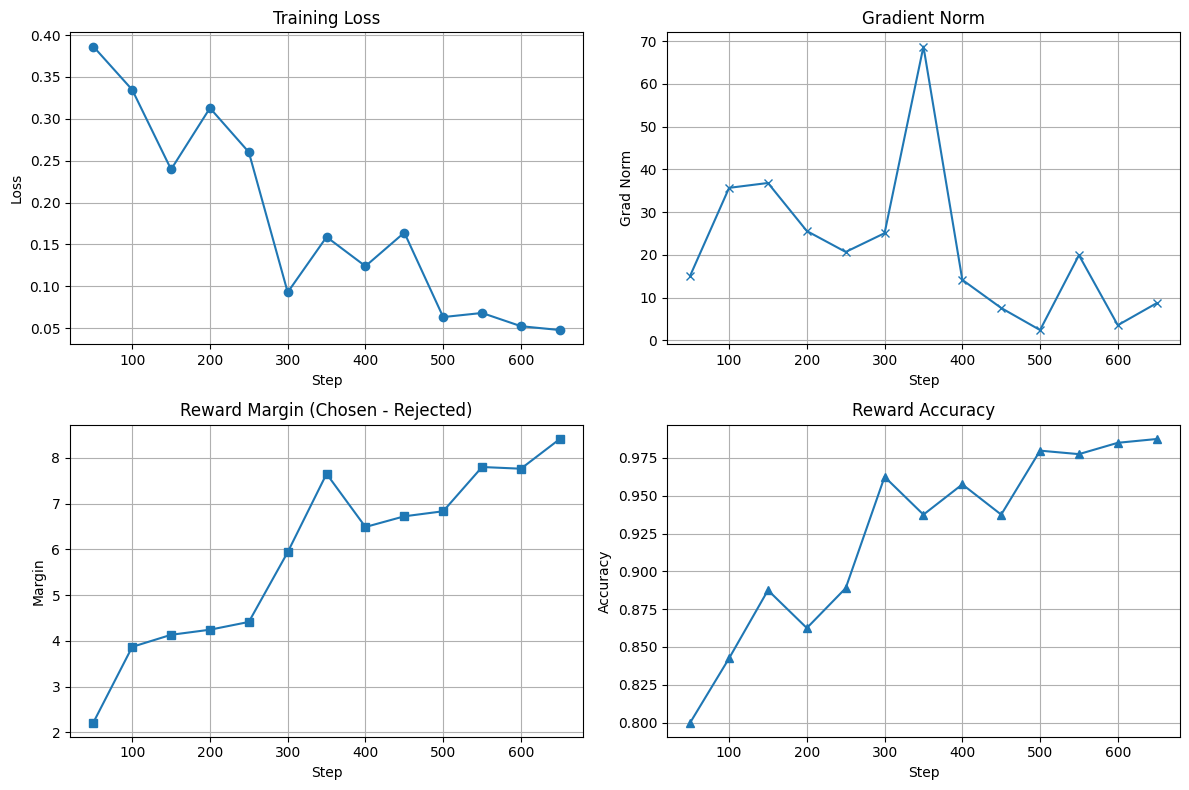

In [11]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(steps, losses, marker='o')
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Step")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)

axs[0, 1].plot(steps, grad_norms, marker='x')
axs[0, 1].set_title("Gradient Norm")
axs[0, 1].set_xlabel("Step")
axs[0, 1].set_ylabel("Grad Norm")
axs[0, 1].grid(True)

axs[1, 0].plot(steps, reward_margins, marker='s')
axs[1, 0].set_title("Reward Margin (Chosen - Rejected)")
axs[1, 0].set_xlabel("Step")
axs[1, 0].set_ylabel("Margin")
axs[1, 0].grid(True)

axs[1, 1].plot(steps, accuracies, marker='^')
axs[1, 1].set_title("Reward Accuracy")
axs[1, 1].set_xlabel("Step")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig(f"plots/{DPO_PATH}-training-metrics.pdf", format="pdf")
plt.show()
plt.close()


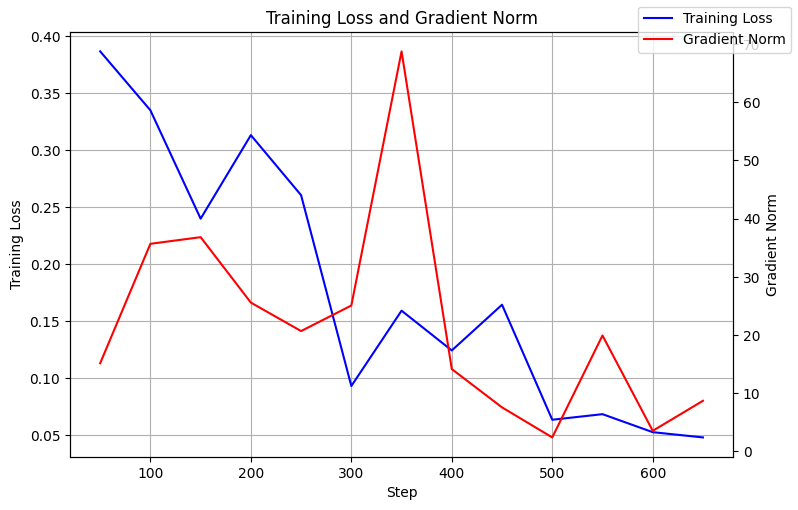

In [12]:
# -------------------
# Plot 1: Loss & Grad Norm
# -------------------

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Step")
ax1.set_ylabel("Training Loss")
l1, = ax1.plot(steps, losses, color='blue', label="Training Loss")
ax1.tick_params(axis='y')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Gradient Norm")
l2, = ax2.plot(steps, grad_norms, color='red', label="Gradient Norm")
ax2.tick_params(axis='y')

# Combine both line objects into one legend
lines = [l1, l2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.title("Training Loss and Gradient Norm")
plt.savefig(f"plots/{DPO_PATH}-loss-gradnorm.pdf", format="pdf")
plt.show()
plt.close()


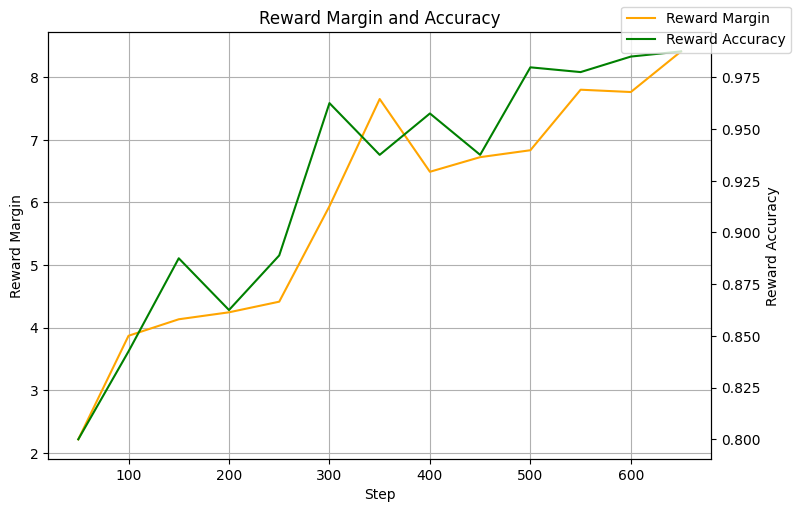

In [13]:
# -------------------
# Plot 2: Reward Margin & Accuracy
# -------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Step")
ax1.set_ylabel("Reward Margin")
l1, = ax1.plot(steps, reward_margins, color='orange', label="Reward Margin")
ax1.tick_params(axis='y')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Reward Accuracy")
l2, = ax2.plot(steps, accuracies, color='green', label="Reward Accuracy")
ax2.tick_params(axis='y')

# Combine both line objects into one legend 
lines = [l1, l2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.title("Reward Margin and Accuracy")
plt.savefig(f"plots/{DPO_PATH}-margin-accuracy.pdf", format="pdf")
plt.show()
plt.close()


# Response Generation

In [1]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Dataset = "Blended Skill Talk"       
Dataset = "IT-ConvAI2"       
# Dataset = "FoCus"       

In [3]:
import pandas as pd
import warnings
import logging
import torch
import torch

torch.cuda.empty_cache()

warnings.filterwarnings("ignore")
logging.getLogger('transformers').setLevel(logging.ERROR)


# Loading the prompt
df = pd.read_csv(f'./Prompts/{Dataset}.csv')

df.head(10)

,personas,context,act_response
0,i love disneyland and mickey mouse.i love to s...,"User1: no , we recently purchased a new house ...",User2: yes i love mickey mouse such a cute lit...
1,i love to drink fancy tea.i have a big library...,User1: hi how are you doing ? i am okay how ab...,User2: i am doing good . just sipping tea . wh...
2,im a little girl.ive superpowers.i like to mak...,User1: what is your name ? are you a male or f...,User2: im a girl . i do not give out my name .
3,i love cats and have two cats.my favorite seas...,User1: hi ! do you like turtles ?,User2: i am much more of a cat person actually
4,i love cats and have two cats.my favorite seas...,User1: what are your kitties names ?,"User2: snow and winter , named after my favori..."
5,i love cats and have two cats.my favorite seas...,User1: how old are you ? i turned four on my b...,User2: i am an old woman . i won a gold medal ...
6,i love cats and have two cats.my favorite seas...,User1: wow ! ! you won gold ! are you rich ?,User2: no . i spend all of my money on hats ! ...
7,i volunteer at a soup kitchen.cheeseburgers ar...,User1: what do you like to do in your spare ti...,User2: i actually have purple hair and i love ...
8,i volunteer at a soup kitchen.cheeseburgers ar...,"User1: those are fun . ive a cat , do you ?",User2: ive a bird and she loves cheeseburgers ...
9,i volunteer at a soup kitchen.cheeseburgers ar...,User1: do you like the holidays ? i dont .,User2: i do love the holidays i volunteer a so...


In [4]:
# Function to generate a prompt
def create_prompt(personas, context, include_cot=False):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if include_cot:
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if include_cot:
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

COT_SETUP = False                                  # Chain Of Thoughts Configuration

####### Benchmark ########
LLM_name = "Qwen2-5B-Benchmark"

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-0.5B-Instruct", torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")


########  DPO   ########

# LLM_name = "Qwen2-5B-DPO"     
# LLM_name = "Qwen2-5B-DPO-AVG"     
# LLM_name = "Qwen2-5B-DPO-LENGTH-PRIOR"     

# checkpoint_path = f"{LLM_name}/checkpoint-699"

# model = AutoModelForCausalLM.from_pretrained(checkpoint_path, torch_dtype=torch.float32)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

############################


MAX_NEW_TOKEN = 220 if COT_SETUP else 110

generation_params = {
    
    "max_new_tokens": MAX_NEW_TOKEN,      # Based on max response length + reasoning
    "temperature": 0,                     # Based on FELM paper (Greedy Setup)
    "do_sample": False
}

In [6]:
first_row = df.iloc[10]
personas = first_row['personas']
context = first_row['context']

# Example usage
prompt = create_prompt(personas, context, include_cot=COT_SETUP)
print(prompt)

I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.
As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.

Participant Personas:
i volunteer at a soup kitchen.cheeseburgers are my favorite food.i was poor growing up.i like watching war documentaries

Conversation Context:
User1: i get depressed . how old are you ? im very old .

Task Instruction:
* Provide an unannotated response.
* If only one persona is available, personalize the response accordingly.
* If the conversation context is a single query, respond appropriately to the query.

Output Format: only give a JSON of the following format:
{
  "response": "provide the personalized natural language response here (in 110 words or less)."
}



In [7]:
from transformers import pipeline

# Initialize the text generation pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=device)

# Generate a response
output = generator(prompt, **generation_params)
response = output[0]['generated_text'][len(prompt):]

# Print the response
print(response)

Note: The response should not contain any personal pronouns.

{"response": "Sorry, but I don't have enough information to answer your question about my age."}


In [8]:
import time
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Iterate through the DataFrame and generate responses
gen_responses = []
response_times = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating responses"):
    personas = row['personas']
    context = row['context']
    
    # Create the prompt
    prompt = create_prompt(personas, context, COT_SETUP)
    
    # Measure the start time
    start_time = time.time()
    
    # Generate a response
    output = generator(prompt, **generation_params)[0]['generated_text']
    
    # Measure the end time and calculate the duration
    end_time = time.time()
    response_time = end_time - start_time
    
    response = output[len(prompt):]

    # Store the generated response and response time
    gen_responses.append(response)
    response_times.append(response_time)

# Create a DataFrame with the responses and response times
response_df = pd.DataFrame({
    'gen_response': gen_responses,
    'response_time': response_times
})  

COT_ = "-COT" if COT_SETUP else "" 

## Save the response DataFrame to a CSV and Excel file
response_df.to_csv(f'./Raw Responses/{Dataset}/{LLM_name}{COT_}.csv', index = False)

Generating responses: 100%|██████████| 1183/1183 [10:36<00:00,  1.86it/s]


In [9]:
response_df.head(20)

,gen_response,response_time
0,Note: The response should not contain any pers...,0.355812
1,Note: The response should not contain any pers...,0.774501
2,Note: The response should not contain any pers...,0.379174
3,Note: The response should not contain any pers...,0.488048
4,Note: The response should not contain any pers...,0.306784
5,Note: The response should not contain any pers...,0.685774
6,Note: The response should not contain any pers...,0.531355
7,Note: The response should not contain any pers...,0.281676
8,Note: The response should not contain any pers...,0.615678
9,Note: The response should not contain any pers...,0.388455
